In [8]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from tensorboard.backend.event_processing import event_accumulator

# === Function to convert TF events to CSV ===
def convert_tf_to_csv(tfevent_path, save_folder):
    ea = event_accumulator.EventAccumulator(tfevent_path)
    ea.Reload()
    tags = ea.Tags()["scalars"]
    saved_files = []
    for tag in tags:
        events = ea.Scalars(tag)
        df = pd.DataFrame([(e.step, e.wall_time, e.value) for e in events],
                          columns=["step", "wall_time", "value"])
        filename = f"{tag.replace('/', '_')}.csv"
        save_path = os.path.join(save_folder, filename)
        df.to_csv(save_path, index=False)
        saved_files.append(save_path)
        print(f"Saved: {os.path.abspath(save_path)}")
    return saved_files

# === List of TF event files and their metadata ===
df_info = pd.read_csv("/Users/julian/projects/University/Period5/FederatedLearning-SNN/non-iid.csv")  # must have columns: filepath, folder, aggregation, method, num_clients
tf_event_files = []
for _, row in df_info.iterrows():
    folder = os.path.dirname(row["filepath"])
    filename = os.path.basename(row["filepath"])
    tf_event_files.append((folder, filename, row["aggregation"], row["method"], row["num_clients"]))

print("Starting TF event to CSV conversion...")

for folder, filename, agg, method, n_clients in tf_event_files:
    os.makedirs(folder, exist_ok=True)
    full_path = os.path.join(folder, filename) 
    convert_tf_to_csv(full_path, folder)
print("Conversion done. Waiting 15 seconds before proceeding...")
for remaining in range(15, 0, -1):
    print(f"Continuing in {remaining} seconds...", end='\r')
    time.sleep(1)
print("Proceeding with plotting.\n")

# === Now read the CSV paths and metadata from a file (or build it here) ===
# You can replace this with your actual 'plot_path.csv' reading

# For demo, build dataframe manually from converted CSVs
all_csv_files = []
all_metadata = []

for folder, filename, agg, method, n_clients in tf_event_files:
    # List all CSVs generated in the folder after conversion
    files = [f for f in os.listdir(folder) if f.endswith("centralized_accuracy.csv")]
    for f in files:
        all_csv_files.append(os.path.join(folder, f))
        all_metadata.append({
            "filepath": os.path.join(folder, f),
            "aggregation": agg,
            "method": method,
            "num_clients": n_clients
        })

    print(files)

Starting TF event to CSV conversion...
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedavg/centralized_accuracy.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedavg/distributed_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedavg/centralized_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedprox/centralized_accuracy.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedprox/distributed_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/federated_server/non-iid/fedprox/centralized_loss.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/surrogate_gradients

    step     wall_time      value aggregation     method  num_clients
0      0  1.749575e+09  10.220000      FedAvg  Eventprop            5
1      1  1.749575e+09  30.290001      FedAvg  Eventprop            5
2      2  1.749575e+09  75.580002      FedAvg  Eventprop            5
3      3  1.749575e+09  74.570000      FedAvg  Eventprop            5
4      4  1.749575e+09  64.510002      FedAvg  Eventprop            5
..   ...           ...        ...         ...        ...          ...
92     6  1.749478e+09   0.938884     FedProx         SG            5
93     7  1.749478e+09   0.946796     FedProx         SG            5
94     8  1.749478e+09   0.951048     FedProx         SG            5
95     9  1.749478e+09   0.954905     FedProx         SG            5
96    10  1.749478e+09   0.955993     FedProx         SG            5

[97 rows x 6 columns]


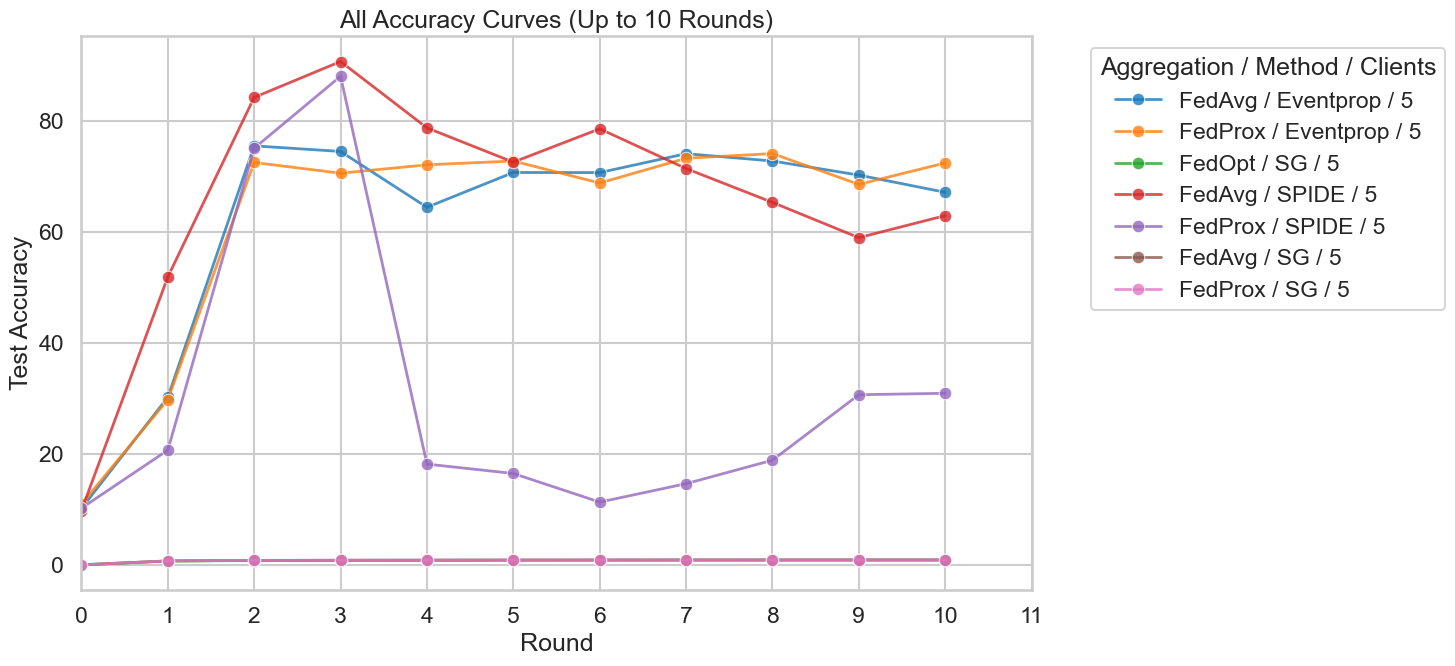

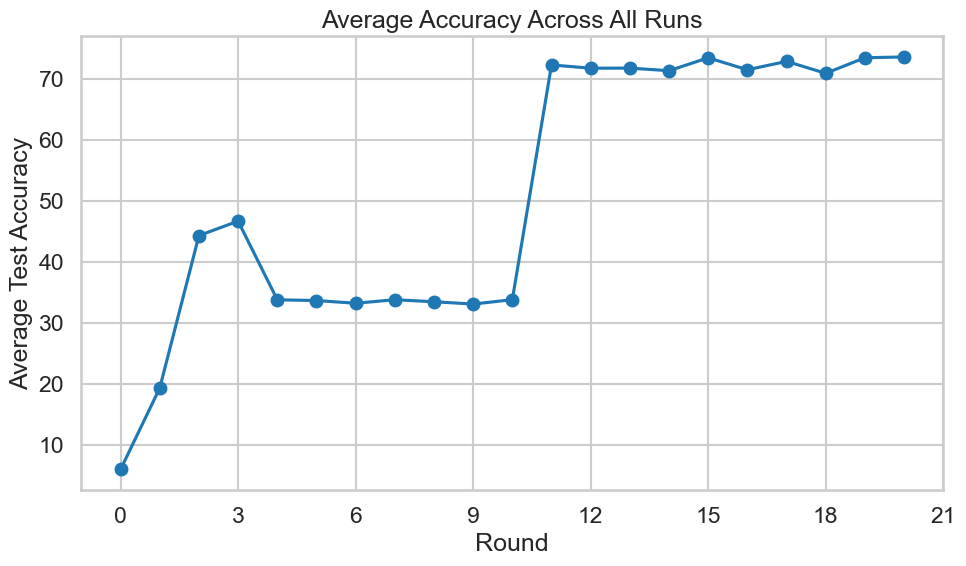

In [17]:
df_meta = pd.DataFrame(all_metadata)

# --- Load CSV data and assign metadata ---
all_dfs = []
for idx, row in df_meta.iterrows():
    try:
        df = pd.read_csv(row['filepath'], encoding='latin1')
        df['aggregation'] = row['aggregation']
        df['method'] = row['method']
        df['num_clients'] = row['num_clients']
        all_dfs.append(df)
    except Exception as e:
        print(f"Skipping {row['filepath']} due to error: {e}")

combined_df = pd.concat(all_dfs, ignore_index=True)

# --- Plot all accuracy curves ---
sns.set(style="whitegrid", context="talk", palette="colorblind")

print(combined_df)
combined_df['label'] = combined_df.apply(
    lambda row: f"{row['aggregation']} / {row['method']} / {row['num_clients']}", axis=1
)

combined_df_small = combined_df[combined_df['step'] <= 10]

plt.figure(figsize=(15, 7))  # Make figure wider
sns.lineplot(
    data=combined_df_small,
    x='step', y='value',
    hue='label',
    palette='tab10',
    estimator=None,
    alpha=0.8,
    linewidth=2,
    marker='o'
)
plt.title("All Accuracy Curves (Up to 10 Rounds)")
plt.xlabel("Round")
plt.ylabel("Test Accuracy")
plt.legend(title="Aggregation / Method / Clients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.xlim(0, 10)
plt.xticks(range(12))
plt.show()

# --- Plot average accuracy over all runs combined (single curve) ---
avg_df = combined_df.groupby('step', as_index=False)['value'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_df['step'], avg_df['value'], marker='o', color='tab:blue')
plt.title("Average Accuracy Across All Runs")
plt.xlabel("Round")
plt.ylabel("Average Test Accuracy")
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()